In [2]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrix, dmatrices

In [50]:
# All GPCR targets
gpcr_targets = pd.read_csv('../data/gene_annotations/GuideToPharm_GPCR_targets_refined_060121.csv')
# Precomputed constraint metrics from gnomAD
gpcr_constraint = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_precomputed_constraint.csv',index_col=0)
# Drug target data 
gpcr_drug_targets = pd.read_csv('../data/drug_annotations/GPCR_drug_targets_by_MOAsmp_and_ATClvl1.csv',index_col=0)
# Drug target class
gpcr_classes = pd.read_csv('../data/gene_annotations/GPCRdb_class_by_gpcr.csv')

In [54]:
gpcr_drug_targets = (gpcr_drug_targets.groupby('HGNC symbol')
                                      .agg({'MOA_simplified':lambda x: '_'.join(np.unique(x))})
                                      .reset_index())
gpcr_targets_ClassA = gpcr_targets.merge(
    gpcr_classes[gpcr_classes['Class']=='A'],
    on='HGNC symbol'
)

gpcr_targets_by_associated_drugs = gpcr_targets_ClassA.merge(gpcr_drug_targets,how='left',on='HGNC symbol')
gpcr_targets_by_associated_drugs = gpcr_targets_by_associated_drugs[
    ['HGNC symbol','MOA_simplified']
]

gpcr_targets_by_associated_drugs['MOA_simplified'] = \
    gpcr_targets_by_associated_drugs['MOA_simplified'].fillna('None')
gpcr_targets_by_constraint_and_drugs = (gpcr_targets_by_associated_drugs
    .merge(gpcr_constraint,on='HGNC symbol')
    .merge(gpcr_classes, on='HGNC symbol'))

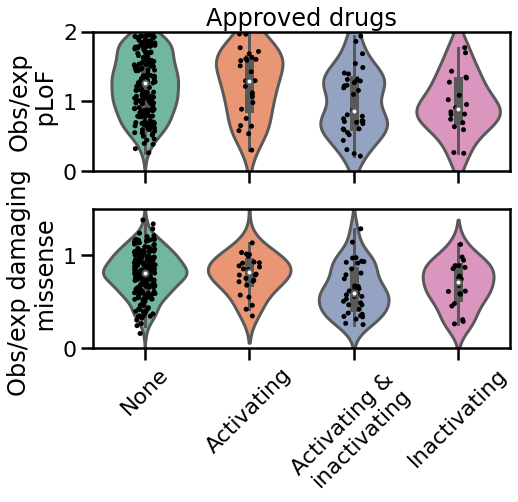

In [63]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,7.5))
sns.set_context('poster')
sns.color_palette("Set2")
sns.stripplot(
    data=gpcr_targets_by_constraint_and_drugs,
    x='MOA_simplified',y='oe_lof_upper',
    ax=ax1, color='black',order=['None','activating','activating_inactivating','inactivating']
)
sns.violinplot(
    data=gpcr_targets_by_constraint_and_drugs,
    x='MOA_simplified',y='oe_lof_upper',
    ax=ax1,order=['None','activating','activating_inactivating','inactivating'],
    palette='Set2'
)
ax1.set_xticklabels([])
_ = ax1.set_ylim((0,2))
ax1.set_title('Approved drugs')
ax1.set_ylabel('Obs/exp\n pLoF')
ax1.set_xlabel('')
sns.stripplot(
    data=gpcr_targets_by_constraint_and_drugs,
    x='MOA_simplified',y='oe_mis_pphen',
    ax=ax2, color='black',order=['None','activating','activating_inactivating','inactivating']
)
sns.violinplot(
    data=gpcr_targets_by_constraint_and_drugs,
    x='MOA_simplified',y='oe_mis_pphen',
    ax=ax2,order=['None','activating','activating_inactivating','inactivating'],
    palette='Set2'
)
ax2.set_xticklabels(['None','Activating','Activating & \ninactivating','Inactivating'],rotation=45)
_ = ax2.set_ylim((0,1.5))
ax2.set_yticks((0,1))
ax2.set_xlabel('')
ax2.set_ylabel('Obs/exp damaging \n missense')
plt.tight_layout()
plt.savefig('../plots/overall_constraint/drug_target_constraint_boxplots_poster.png',dpi=500)

In [62]:
l = ['None','Autosomal recessive','Dominant or X-linked']
y, X = dmatrices(
    'oe_mis_pphen ~ \
        C(MOA_simplified)',
    gpcr_targets_by_constraint_and_drugs
)
model = sm.OLS(y,X) 
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           oe_mis_pphen   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.043
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           0.000533
Time:                        15:32:56   Log-Likelihood:                0.47583
No. Observations:                 283   AIC:                             7.048
Df Residuals:                     279   BIC:                             21.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.8045      0.017     47.001      0.000       0.771       0.838
C(MOA_simplified)[T.activating]                  0.0232      0.051      0.457      0.648      -0.077       0.123
C(MOA_simplified)[T.activating_inactivating]    -0.1673      0.045     -3.755      0.000      -0.255      -0.080
C(MOA_simplified)[T.inactivating]               -0.1197      0.057     -2.098      0.037      -0.232      -0.007
==============================================================================
Omnibus:                        1.470   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.197
Skew:                           0.078   Prob(JB):                        0.550
Kurtosis:                       3.278   Cond. No.                         4.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
l = ['None','Autosomal recessive','Dominant or X-linked']
y, X = dmatrices(
    'oe_lof_upper ~ \
        C(MOA_simplified)',
    gpcr_targets_by_constraint_and_drugs
)
model = sm.OLS(y,X) 
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           oe_lof_upper   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     5.008
Date:                Wed, 17 Mar 2021   Prob (F-statistic):            0.00215
Time:                        13:24:16   Log-Likelihood:                -158.95
No. Observations:                 272   AIC:                             325.9
Df Residuals:                     268   BIC:                             340.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.2327      0.032     38.960      0.000       1.170       1.295
C(MOA_simplified)[T.activating]                  0.0160      0.091      0.175      0.861      -0.164       0.196
C(MOA_simplified)[T.activating_inactivating]    -0.2468      0.080     -3.070      0.002      -0.405      -0.089
C(MOA_simplified)[T.inactivating]               -0.2651      0.103     -2.580      0.010      -0.467      -0.063
==============================================================================
Omnibus:                       34.569   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.793
Skew:                          -0.059   Prob(JB):                      0.00747
Kurtosis:                       2.078   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""